In [1]:
import pandas as pd
import numpy as np
import requests
import datetime as dt
from jinja2 import Template
from IPython.display import HTML
import json

In [2]:
with open('abb_dict.json','r') as f:
    abb_dict = json.load(f)

### Above I have a dictionary that converts the table

In [3]:
#write a function that checks if all last index values are zero, and also selects the appropriate date columns
def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['stateABB','states'])]
    valid_i = -1
    for i in range(-1,-len(dt_cols),-1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            valid_i = i
            break
    return valid_i, dt_cols

In [4]:
def get_frame(name):
#    pdb.set_trace()
    url = f'http://api.covid19india.org/states_daily_csv/{name}.csv'
    df = pd.read_csv(url)
    df.set_index('date',inplace = True)
    df = df.T
    df = df.iloc[:-1,:]
    df.fillna(0,inplace=True)
    df = df[df.columns].astype(int)
    df = df.rename_axis('stateABB').reset_index()
    df['states'] = df['stateABB'].map(abb_dict)
    df = df[[df.columns[-1]] + list(df.columns[:-1])]
    df =df.iloc[1:,:]
    df = df[df.states.notna()]
    df.sort_values(by = [df.columns[-1]], ascending = False, inplace = True)
    df.drop(['stateABB'],axis = 1)
    df = df.groupby('states').sum().cumsum(axis=1)
    df.reset_index(inplace = True)
    return df

In [5]:
dft_cases = get_frame('confirmed')
dft_deaths = get_frame('deceased')

In [6]:
valid_i, dt_cols = get_dates(dft_cases)
dt_today = dt_cols[valid_i]
dt_yday = dt_cols[valid_i -1]

In [7]:
dfc_cases = dft_cases.groupby('states')[dt_today].sum()
dfc_deaths = dft_deaths.groupby('states')[dt_today].sum()
dfp_cases = dft_cases.groupby('states')[dt_yday].sum()
dfp_deaths = dft_deaths.groupby('states')[dt_yday].sum()

In [8]:
# Build the cases table
df_table = (pd.DataFrame(dict(Cases = dfc_cases, Deaths = dfc_deaths, PCases = dfp_cases, PDeaths = dfp_deaths))
            .sort_values(by = ['Cases','Deaths'], ascending = [False, False])
            .reset_index())
for c in 'Cases, Deaths'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)
    #Clip ça veut dire, les chiffres negatif sont interdit
df_table['Fatality Rate'] = (100* df_table['Deaths']/ df_table['Cases']).round(2)

In [9]:
df_table.head()

states  Cases  Deaths  PCases  PDeaths  Cases (+)  Deaths (+)  \
0     Maharashtra   7628     322    6817      300        811          22   
1         Gujarat   3071     133    2815      127        256           6   
2           Delhi   2625      54    2514       53        111           1   
3       Rajasthan   2083      34    2034       32         49           2   
4  Madhya Pradesh   1945     100    1846       93         99           7   

   Fatality Rate  
0           4.22  
1           4.33  
2           2.06  
3           1.63  
4           5.14

In [10]:
#Building the summary tab
metrics = [df_table.columns[index] for index in [1,2,5,6]]
s_mah = df_table[df_table.states == 'Maharashtra'][metrics].sum().add_prefix('MH ').astype(int)
s_del = df_table[df_table.states =='Delhi'][metrics].sum().add_prefix('DEL ').astype(int)
s_guj = df_table[df_table.states == 'Gujarat'][metrics].sum().add_prefix('GUJ ').astype(int)
summary = {'updated': pd.to_datetime(dt_today).date(), 'since': pd.to_datetime(dt_yday).date()}
summary = {**summary, **df_table[metrics].sum().astype(int), **s_mah, **s_del, **s_guj}

In [11]:
def myconverter(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, datetime.datetime):
            return obj.__str__()
        elif isinstance(obj, datetime.date):
            return obj.__str__()

In [12]:
import json,datetime
print(json.dumps(summary, default = myconverter, indent=10, sort_keys=False))

{
          "updated": "2020-04-25",
          "since": "2020-04-24",
          "Cases": 26177,
          "Deaths": 824,
          "Cases (+)": 1832,
          "Deaths (+)": 44,
          "MH Cases": 7628,
          "MH Deaths": 322,
          "MH Cases (+)": 811,
          "MH Deaths (+)": 22,
          "DEL Cases": 2625,
          "DEL Deaths": 54,
          "DEL Cases (+)": 111,
          "DEL Deaths (+)": 1,
          "GUJ Cases": 3071,
          "GUJ Deaths": 133,
          "GUJ Cases (+)": 256,
          "GUJ Deaths (+)": 6
}


In [13]:
#Data on new cases
dft_ct_new_cases = dft_cases.groupby('states')[dt_cols].sum().diff(axis=1).fillna(0).astype(int)
dft_ct_new_cases.sort_values(by = [dft_ct_new_cases.columns[-1]], ascending = False,inplace = True)

In [14]:
# Get total number from world data only
COL_REGION = 'states'
KPI_CASE = 'India'
kpis_info = [
    {'title': 'Maharashtra', 'prefix': 'MH'},
    {'title': 'Delhi', 'prefix': 'DEL'},
    {'title': 'Gujarat', 'prefix': 'GUJ'}]

In [15]:
#hide
def get_template(path):
    from urllib.parse import urlparse
    if bool(urlparse(path).netloc):
        from urllib.request import urlopen
        return urlopen(path).read().decode('utf8')
    return open(path).read()

In [16]:
#hide_input
template = Template(get_template('https://raw.githubusercontent.com/hargun3045/dashboards/master/overview.tpl'))
#Local method
#with open('overview.tpl','r') as f:
#     temp = f.read()
#template = Template(temp)
html = template.render(
    D=summary, table=df_table,
    KPI_CASE = KPI_CASE,COL_REGION = COL_REGION,
    KPIS_INFO = kpis_info,# REMOVE .head(20) to see all values
    newcases=dft_ct_new_cases.loc[:, dt_cols[valid_i-14]:dt_cols[valid_i]],
    np=np, pd=pd, enumerate=enumerate)
HTML(f'<div>{html}</div>')

## Les experiments!

In [17]:
df = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv')

In [18]:
#Don't know why he's doing the following steps
quartiles = np.percentile(df['births'], [25,50,75])

mu, sig = quartiles[1], 0.74*(quartiles[2] - quartiles[0])

births = df.query('(births > @mu - 5*@sig) & (births < @mu + 5*@sig)')

In [22]:
births['day'] = births['day'].astype(int)

/Users/hargunoberoi/Desktop/Programming/anaconda3/envs/univai/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
births.index = pd.to_datetime(10000*births.year + 
                             100*births.month + 
                             births.day , format = '%Y%m%d')

births_by_date = births.pivot_table('births',[births.index.month, births.index.day])

births_by_date.index = [pd.datetime(2012, month, day) for month, day in births_by_date.index]
#final plot is of a datetime index with births column

/Users/hargunoberoi/Desktop/Programming/anaconda3/envs/univai/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


# Above is the code by Jake VanderPlas,
## Below is my own implementation

In [24]:
births.index = pd.to_datetime(20120000 + 
                             100*births.month + 
                             births.day , format = '%Y%m%d')

In [25]:
births_by_date = births.pivot_table('births',[births.index.month, births.index.day])

births_by_date.index = [pd.datetime(2012, month, day) for month, day in births_by_date.index]
#final plot is of a datetime index with births column

/Users/hargunoberoi/Desktop/Programming/anaconda3/envs/univai/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl

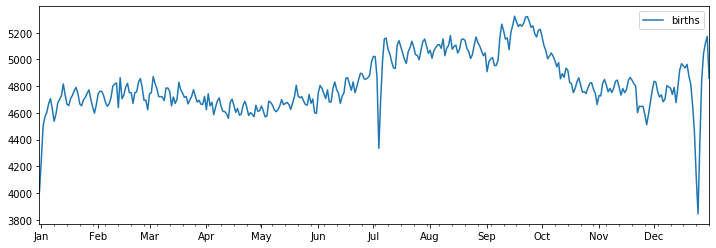

In [29]:
fig, ax = plt.subplots(figsize = (12,4))
births_by_date.plot(ax=ax)
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))

NameError: name 'ef' is not defined

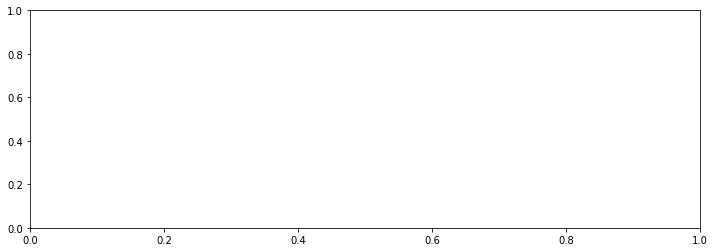

In [30]:
fig, ax = plt.subplots(figsize = (12,4))
ef.set_index('date').plot(ax=ax)
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))

In [31]:
import seaborn as sns

AttributeError: 'Series' object has no attribute 'date'

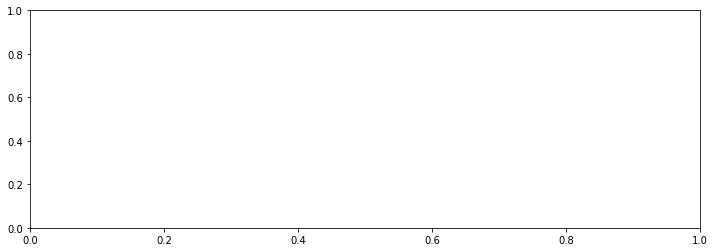

In [50]:
fig, ax = plt.subplots(figsize = (12,4))
# ef.set_index('date').plot(kind = 'bar',ax=ax)
ax.bar(ef.date,ef.cases)

ax2 = ax.twinx()
ax2.plot(ef.date, ef.cases.rolling(7).mean(), color = 'r')

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


# Add text for location

# Add text for Cases

textstr = '\n'.join((
f"State: {m['states']}",
f"Total Cases: {m['Cases']} (+{m['Cases (+)']})",
f"Total Deaths: {m['Deaths']}(+{m['Deaths (+)']})",
f"Fatality: {m['Fatality Rate']}"
))

ax.text(0.02, 0.55, textstr,transform = ax.transAxes, fontsize = 20);
# ax.legend(['A','B'],loc = 'best', fontsize = 25)
# plt.savefig('./DreamImages/2018v2019.jpeg')
ax2.set_yticks([])
sns.despine()

NameError: name 'mdates' is not defined

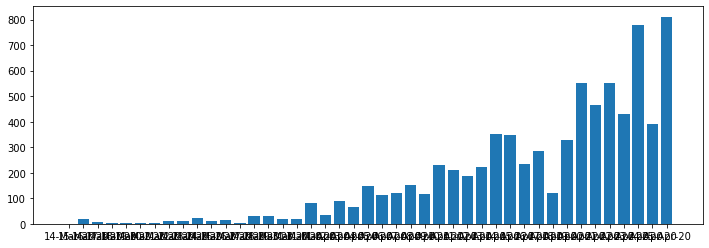

In [54]:
fig, ax = plt.subplots(figsize = (12,4))
# ef.set_index('date').plot(kind = 'bar',ax=ax)
ef = ef.reset_index()
ax.bar(ef.date,ef.Maharashtra)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))



# Add text for location

# Add text for Cases

textstr = '\n'.join((
f"State: {m['states']}",
f"Total Cases: {m['Cases']} (+{m['Cases (+)']})",
f"Total Deaths: {m['Deaths']}(+{m['Deaths (+)']})",
f"Fatality: {m['Fatality Rate']}%",
f"Last updated: {dt_today}"
))

ax.text(0.02, 0.55, textstr,transform = ax.transAxes, fontsize = 20);
# ax.legend(['A','B'],loc = 'best', fontsize = 25)
# plt.savefig('./DreamImages/2018v2019.jpeg')
ax2.set_yticks([])
sns.despine()

In [34]:
n = 10

In [35]:
ax = []

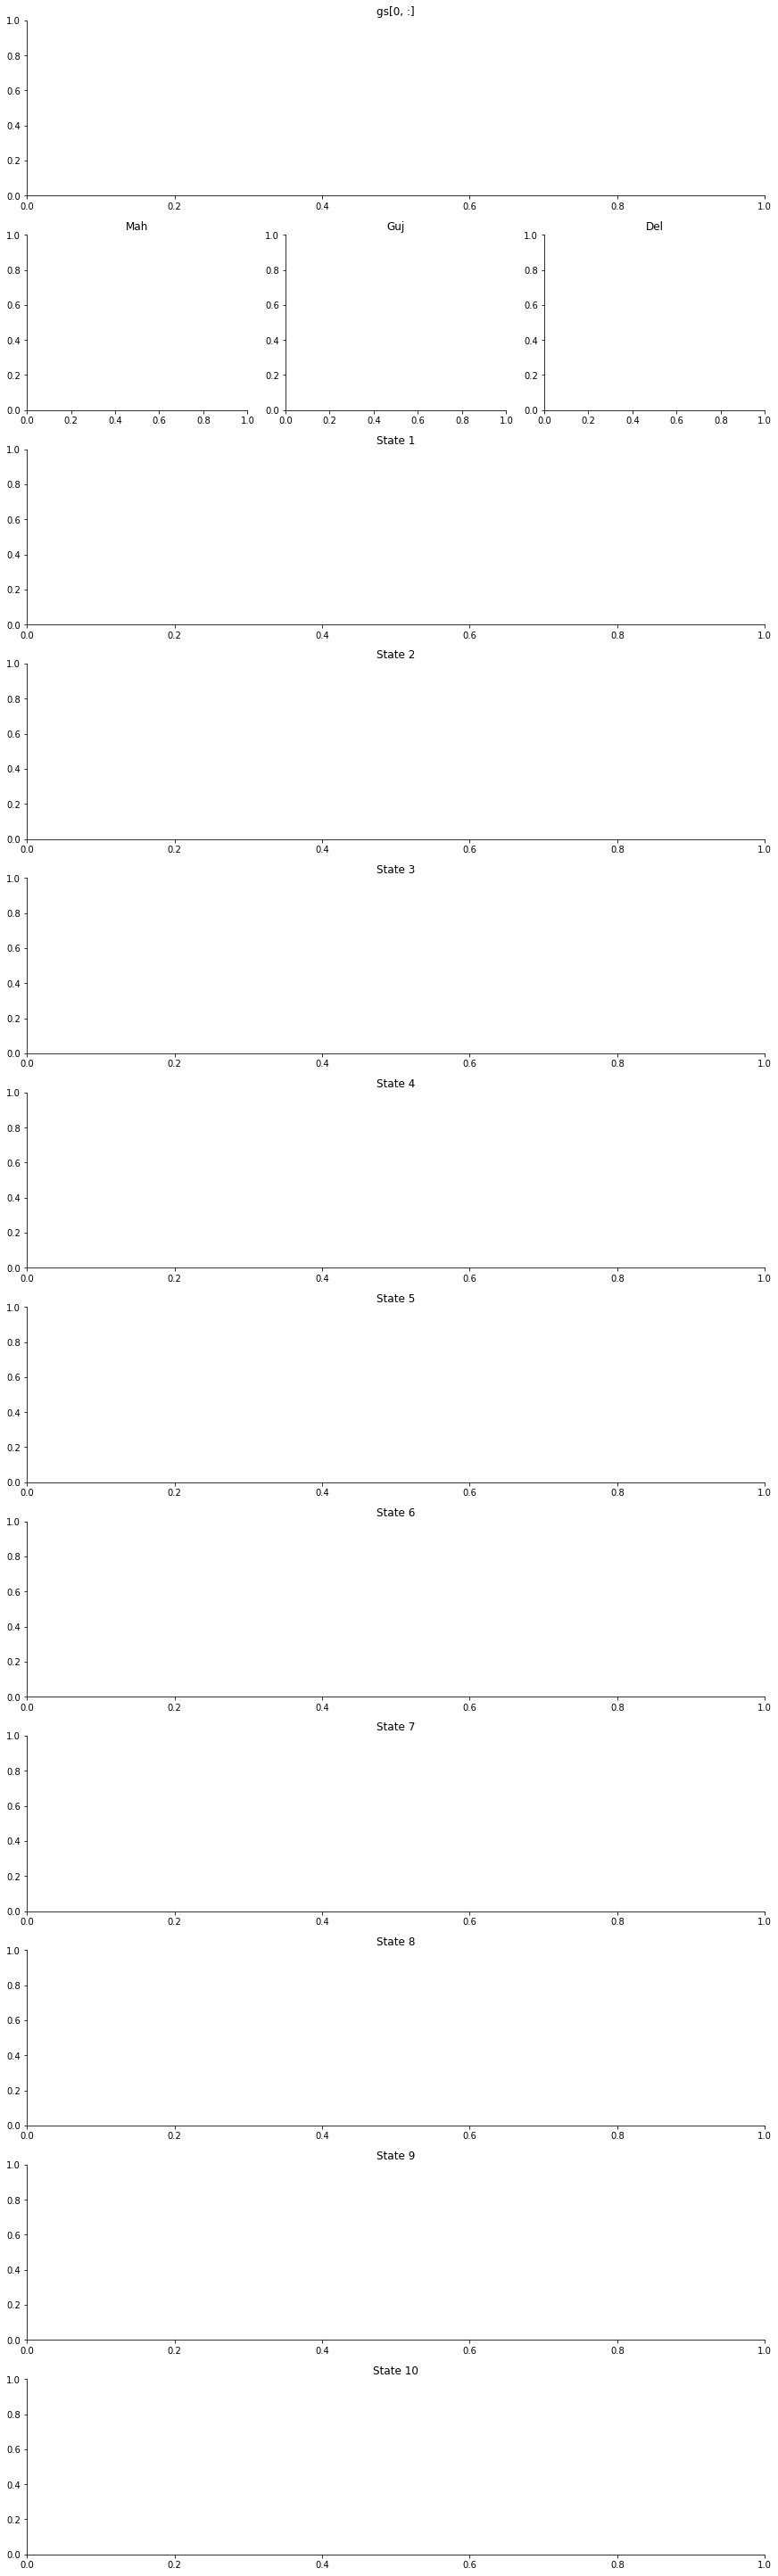

In [36]:
fig3 = plt.figure(constrained_layout=True, figsize = (12,40))
gs = fig3.add_gridspec(n+2, 3)

f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('gs[0, :]')

f3_ax2 = fig3.add_subplot(gs[1,0])
f3_ax2.set_title('Mah')

f3_ax3 = fig3.add_subplot(gs[1,1])
f3_ax3.set_title('Guj')

f3_ax4 = fig3.add_subplot(gs[1,2])
f3_ax4.set_title('Del')

for i in range(n):
    
    ax.append(fig3.add_subplot(gs[i+2,:]))
    ax[i].set_title(f'State {i+1}')
    

sns.despine()